In [1]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
from SuperpixelCutsPy import *
import scipy as sp
import pandas as pd
# Configs for Notebooks
plt.rcParams["figure.figsize"] = [9,7]
np.set_printoptions(linewidth=200)
np.set_printoptions(suppress=True)

In [15]:
dataset_name = 'Salinas A'
hyperspectral_cube = sp.io.loadmat("data/SalinasA_corrected.mat")['salinasA_corrected'] # Load Dataset
ground_truth = sp.io.loadmat("data/SalinasA_gt.mat")['salinasA_gt']
#hyperspectral_cube = hyperspectral_cube[0:55,0:55,:]

#hyperspectral_cube[12,14,:] = hyperspectral_cube[12,10,:]
#ground_truth = ground_truth[0:55,0:55]
ground_truth = np.vectorize(lambda x: {0: 0, 1:1, 10:2, 11:3, 12:4, 13:5, 14:6}[x])(ground_truth)
nx, ny, nb = hyperspectral_cube.shape
# print(hyperspectral_cube.shape)

C:\Users\apopo\AppData\Local\Temp\ipykernel_10996\3806591289.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdBu', np.unique(ground_truth).shape[0] - 1)


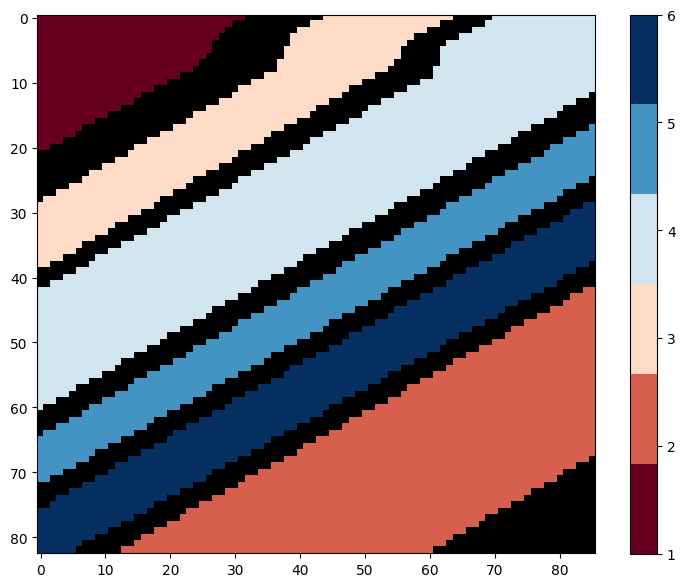

In [30]:
cmap = plt.cm.get_cmap('RdBu', np.unique(ground_truth).shape[0] - 1)
cmap.set_bad(color='black') 
plt.imshow(np.ma.masked_where(ground_truth == 0, ground_truth), cmap=cmap)
plt.colorbar(ticks = np.arange(np.unique(ground_truth).shape[0] + 1));

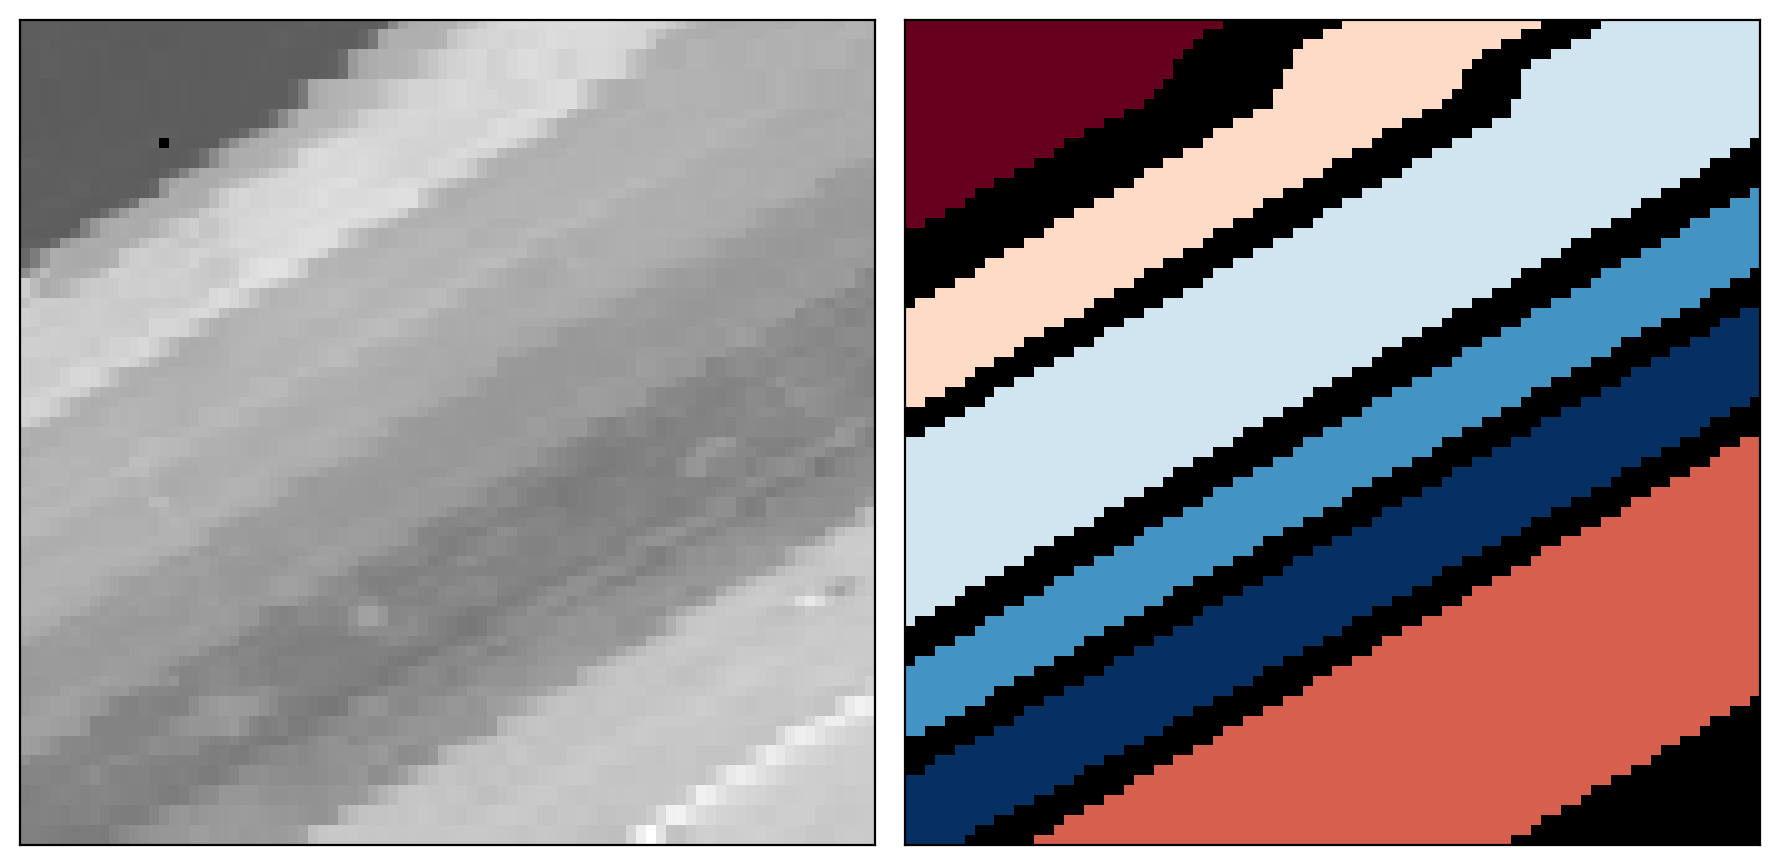

In [76]:
fig, ax = plt.subplots(1,2, dpi=200);
ax[0].imshow(hyperspectral_cube[:,:,25], cmap = 'gray');
ax[1].imshow(np.ma.masked_where(ground_truth == 0, ground_truth), cmap = cmap);
ax[0].set_xticks([]);
ax[0].set_yticks([]);
ax[1].set_xticks([]);
ax[1].set_yticks([]);
plt.tight_layout();


ASC

In [31]:
#Adaptive Superpixel Cuts
preprocessing_pipeline = Preprocesser.Preprocesser(data = hyperspectral_cube)
#preprocessing_pipeline.gaussian_blur(blur_param = 0)
preprocessing_pipeline.singular_value_decomposition(n_svd = 5)
preprocessing_pipeline.layer_normalization()
hyperspectral_cube = preprocessing_pipeline.data.copy()
original_hyperspectral_cube = preprocessing_pipeline.original_data.copy()
print('Preprocessed')

n_superpixels = 300 #2500
slic_m_param = 2  #2
assignments, centers = superpixel.generate_SLIC_assignments(data = hyperspectral_cube,
                                                            n_superpixels = n_superpixels,
                                                            slic_m_param = slic_m_param,
                                                            verbose=True)
superpixeled_cube, superpixel_library = superpixel.generate_SLIC_superpixels(data = hyperspectral_cube,
                                                                             assignments = assignments)
n_superpixels = len(np.unique(assignments))
print('Created Superpixels')

sigma_param = 0.0025 # 0.1 -> 0.001           #0.01
spatial_limit = 20# 15 -> 25 in steps of 5 #15
spatial_beta_param = 0.0025
spatial_dmax_param = spatial_limit
ne = 7#number of endmembers

labelled_img, normalized_signatures, int_results = normalized_cuts.graph_regularized_ncuts_admm(data=hyperspectral_cube,
                                                                                                superpixel_library=superpixel_library,
                                                                                                superpixel_centers=centers,
                                                                                                superpixel_assignments=assignments,
                                                                                                n_endmembers = ne,
                                                                                                spectral_sigma2_param= sigma_param,
                                                                                                spatial_kappa_param=spatial_limit,
                                                                                                spatial_beta_param= spatial_beta_param,
                                                                                                spatial_dmax_param = spatial_dmax_param,
                                                                                                n_unmixing_iters = 200,
                                                                                                spectral_metric='SAM')

original_library  = segmentation_evaluation.calc_mean_label_signatures(utility.cube_to_matrix(original_hyperspectral_cube),
                                                                        labelled_img.reshape(-1))
print('Performed Segmentation')

# fig, ax = plt.subplots(1,3, dpi=150);
# ax[0].imshow(hyperspectral_cube[:,:,20], cmap = 'gray');
# ax[1].imshow((int_results['initial_labels']+1)*(ground_truth != 0), cmap = 'magma');
# ax[2].imshow((labelled_img+1)*(ground_truth != 0), cmap = 'magma');

# ax[0].set_title("Original Image");
# ax[1].set_title("Initial Segmentation");
# ax[2].set_title("Final Segmentation");

# ax[0].set_xticks([]);
# ax[0].set_yticks([]);
# ax[1].set_xticks([]);
# ax[1].set_yticks([]);
# ax[2].set_xticks([]);
# ax[2].set_yticks([]);
# plt.tight_layout();

Preprocessed
Adjusting n_superpixels: 420
Created 420 superpixels
Created Superpixels
Initial Clustering
Spectral + Unmixing Clustering
Performed Segmentation


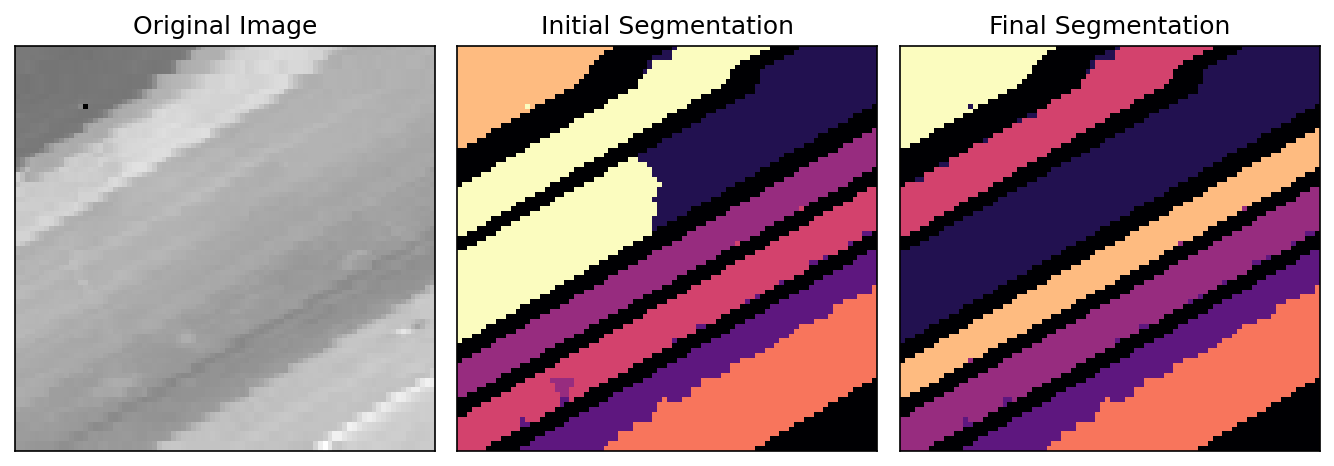

In [33]:

fig, ax = plt.subplots(1,3, dpi=150);
ax[0].imshow(hyperspectral_cube[:,:,20], cmap = 'gray');




ax[1].imshow((int_results['initial_labels']+1)*(ground_truth != 0), cmap = 'magma');
ax[2].imshow((labelled_img+1)*(ground_truth != 0), cmap = 'magma');

ax[0].set_title("Original Image");
ax[1].set_title("Initial Segmentation");
ax[2].set_title("Final Segmentation");

ax[0].set_xticks([]);
ax[0].set_yticks([]);
ax[1].set_xticks([]);
ax[1].set_yticks([]);
ax[2].set_xticks([]);
ax[2].set_yticks([]);
plt.tight_layout();

KMEANS

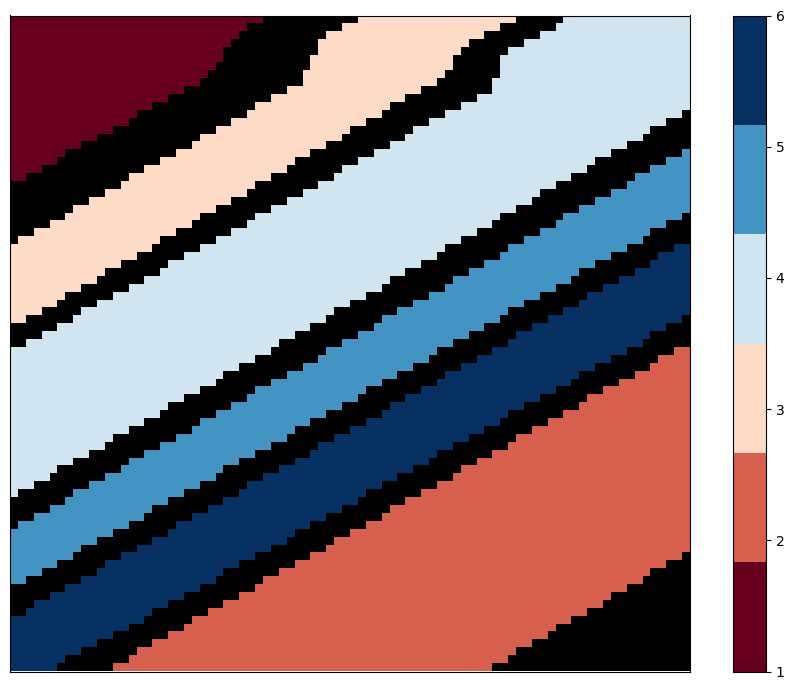

In [78]:
plt.imshow(np.ma.masked_where(ground_truth == 0, ground_truth), cmap=cmap)
plt.colorbar();
plt.xticks([]);
plt.yticks([]);

plt.tight_layout();

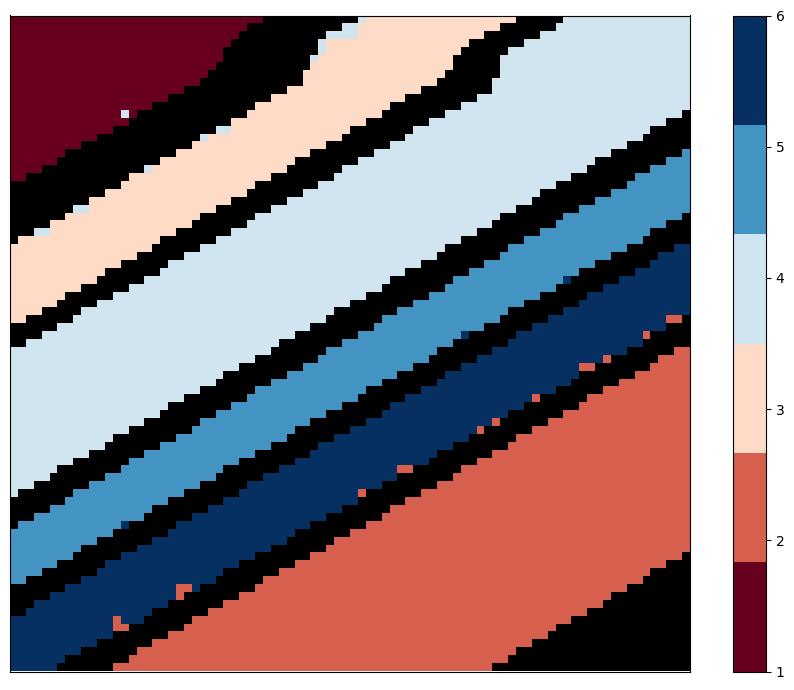

In [64]:
label_map = {   
            0 : 0,
            4 : 3,
            3 : 6,
            1 : 4,
            5 : 2 ,
            2 : 2,
            6 : 5 ,
            7 : 1
        }
final_alg_output = np.vectorize(lambda x: label_map[x])((labelled_img+1)*(ground_truth != 0))

plt.imshow(np.ma.masked_where(final_alg_output == 0, final_alg_output), cmap = cmap)

plt.colorbar(ticks = np.arange(np.unique(ground_truth).shape[0] + 1))
plt.xticks([]);
plt.yticks([]);

plt.tight_layout();

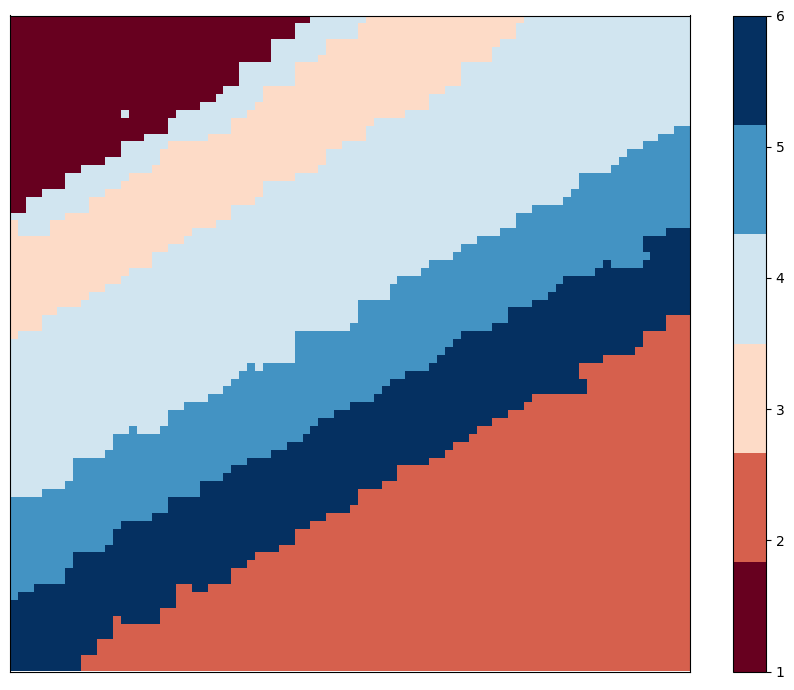

In [65]:
label_map = {   
            # 0 : 0,
            4 : 3,
            3 : 6,
            1 : 4,
            5 : 2 ,
            2 : 2,
            6 : 5 ,
            7 : 1
        }
final_alg_output = np.vectorize(lambda x: label_map[x])((labelled_img+1))

plt.imshow(np.ma.masked_where(final_alg_output == 0, final_alg_output), cmap = cmap)

plt.colorbar(ticks = np.arange(np.unique(ground_truth).shape[0] + 1))
plt.xticks([]);
plt.yticks([]);

plt.tight_layout();

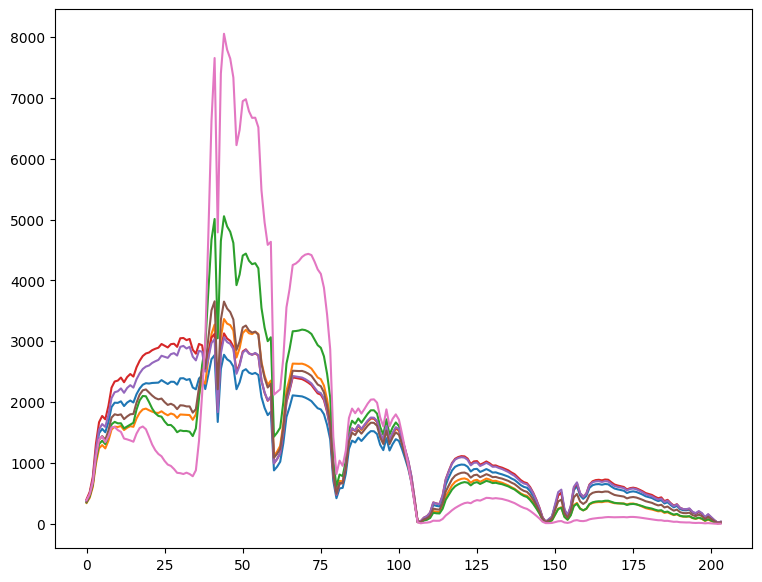

In [66]:
plt.plot(original_library)

In [67]:
import sklearn.metrics as skm
cfm = skm.confusion_matrix(ground_truth.reshape(-1),final_alg_output.reshape(-1), labels = np.unique(ground_truth))[1:, 1:]
np.diag(cfm) / np.sum(cfm, axis=1)

array([0.99744246, 1.        , 0.97077922, 1.        , 0.99554896, 0.97747184])

In [68]:
def calculate_iou(confusion_matrix):
  """
  Calculates Intersection over Union (IoU) for each class in a confusion matrix.

  Args:
      confusion_matrix (numpy.ndarray): The confusion matrix.

  Returns:
      numpy.ndarray: Array containing IoU values for each class.
  """
  true_positives = np.diag(confusion_matrix)  # Extract diagonal elements (true positives)
  # Calculate total predicted positives (sum of each row) and total ground truth positives (sum of each column)
  predicted_positives = np.sum(confusion_matrix, axis=0)
  ground_truth_positives = np.sum(confusion_matrix, axis=1)
  # Avoid division by zero (set to 0 for IoU in such cases)
  iou = np.true_divide(true_positives, predicted_positives + ground_truth_positives - true_positives, where=(predicted_positives + ground_truth_positives - true_positives) != 0)
  return iou

# Example usage (assuming you have a confusion matrix named 'cm')
iou_per_class = calculate_iou(cfm)

In [71]:
np.concatenate([cfm, (np.diag(cfm) / np.sum(cfm, axis=1)).reshape(-1,1),iou_per_class.reshape(-1,1) ] , axis = 1)

array([[ 390.        ,    0.        ,    0.        ,    1.        ,    0.        ,    0.        ,    0.99744246,    0.99744246],
       [   0.        , 1343.        ,    0.        ,    0.        ,    0.        ,    0.        ,    1.        ,    0.98677443],
       [   0.        ,    0.        ,  598.        ,   18.        ,    0.        ,    0.        ,    0.97077922,    0.97077922],
       [   0.        ,    0.        ,    0.        , 1525.        ,    0.        ,    0.        ,    1.        ,    0.9876943 ],
       [   0.        ,    0.        ,    0.        ,    0.        ,  671.        ,    3.        ,    0.99554896,    0.99554896],
       [   0.        ,   18.        ,    0.        ,    0.        ,    0.        ,  781.        ,    0.97747184,    0.97381546]])

In [72]:
np.diag(cfm).sum()/cfm.sum()

0.9925205684367988

In [73]:
import pandas as pd

y_actu = pd.Series(ground_truth.reshape(-1), name='Actual')
y_pred = pd.Series(final_alg_output.reshape(-1), name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred).iloc[1::,1::]
df_confusion

Predicted,2,3,4,5,6
Actual,,,,,
1,0,0,1,0,0
2,1343,0,0,0,0
3,0,598,18,0,0
4,0,0,1525,0,0
5,0,0,0,671,3
6,18,0,0,0,781


In [74]:
(labelled_img+1)

array([[7, 7, 7, ..., 1, 1, 1],
       [7, 7, 7, ..., 1, 1, 1],
       [7, 7, 7, ..., 1, 1, 1],
       ...,
       [3, 3, 3, ..., 5, 5, 5],
       [3, 3, 3, ..., 5, 5, 5],
       [3, 3, 3, ..., 5, 5, 5]])

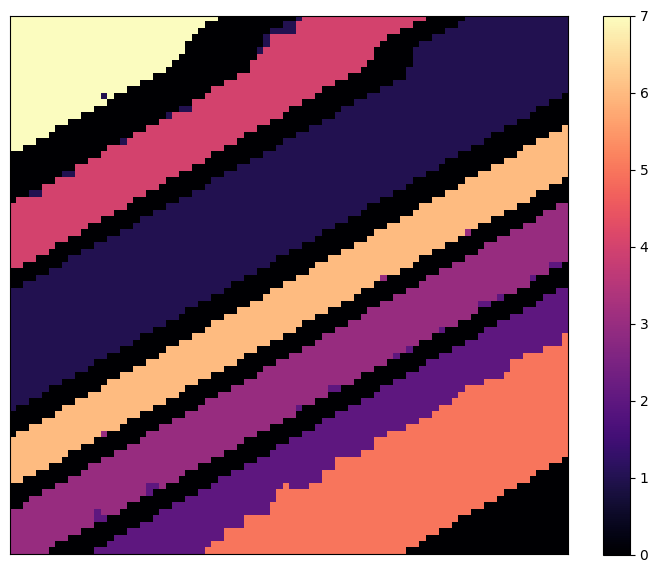

In [75]:
plt.imshow((labelled_img+1)*(ground_truth != 0), cmap = 'magma');
plt.xticks([]);
plt.yticks([]);
plt.colorbar();